In [1]:
import cv2
import numpy as np
import os
import matplotlib.pyplot as plt
# import pandas as pd
import re
import random
import copy
import pylab as pl
from sklearn.metrics import confusion_matrix,accuracy_score

In [2]:
from data_splitting import split_data

## Load data

In [6]:
!pwd

/home/nikolas/Documents/UoE/SEM2/IVC/project/Image_Vision_Computing


In [7]:
# dir paths
cats_dir_path = 'catdog/CATS/'
dogs_dir_path = 'catdog/DOGS/'

# get img names 
_, _, cat_img_names = next(os.walk(cats_dir_path))
_, _, dog_img_names = next(os.walk(dogs_dir_path))

# get img paths
cat_imgs_path = [cats_dir_path+img_name for img_name in cat_img_names]
dog_imgs_path = [dogs_dir_path+img_name for img_name in dog_img_names]

# class names
classes = ['cat', 'dog']

# dict for paths for each img
data_paths = {classes[0]: cat_imgs_path, classes[1]: dog_imgs_path}

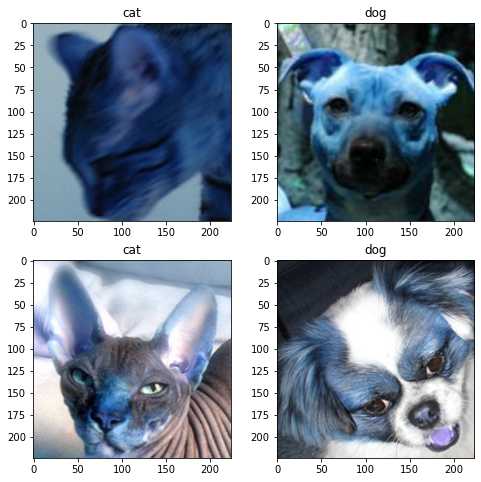

In [8]:
fig = plt.figure(figsize=(8,8))
ax1 = fig.add_subplot(2,2,1)
ax1.imshow(cv2.imread(cat_imgs_path[np.random.randint(100)]))
plt.title(classes[0])

ax2 = fig.add_subplot(2,2,2)
ax2.imshow(cv2.imread(dog_imgs_path[np.random.randint(100)]))
plt.title(classes[1])

ax3 = fig.add_subplot(2,2,3)
ax3.imshow(cv2.imread(cat_imgs_path[np.random.randint(100)]))
plt.title(classes[0])

ax4 = fig.add_subplot(2,2,4)
ax4.imshow(cv2.imread(dog_imgs_path[np.random.randint(100)]))
plt.title(classes[1])

plt.show()

## Prepare A, B, C groups (use this)

In [22]:
from sklearn.model_selection import StratifiedShuffleSplit

In [23]:
from os import walk

img_paths = []
for (dirpath, dirnames, filenames) in walk('catdog'):
    img_paths.extend(filenames)
    
classes = np.zeros(len(img_paths))

for idx, img_path in enumerate(img_paths):
    cls = img_path[:3]
    
    breed_re = re.search('_(.*)_', img_path)
    breed = breed_re.group(1)
    
    if cls == 'cat':
        y = int(breed)
    if cls == 'dog':
        y = 12 + int(breed)
        
    classes[idx] = y
    

In [24]:
# Generating 3 FOLDS for k-fold cross-validation

sss = StratifiedShuffleSplit(n_splits=3, test_size=0.33, random_state=0)

train_indices = []
test_indices = []

for train_index, test_index in sss.split(img_paths, classes):
    print("TRAIN:", train_index.shape, "\nTEST:", test_index.shape)
    print('-----')
    
    train_indices.append(train_index)
    test_indices.append(test_index)

TRAIN: (1599,) 
TEST: (789,)
-----
TRAIN: (1599,) 
TEST: (789,)
-----
TRAIN: (1599,) 
TEST: (789,)
-----


In [55]:
# # Generating TRAINING and VALIDATION set from the two folds that are not used for TESTING

# train_indices_ = []
# validation_indices = []
    
# for fold in train_indices:
#     fold_classes = [classes[i] for i in fold]
    
#     sss_fold = StratifiedShuffleSplit(n_splits=1, test_size=0.25, random_state=0)
    
#     for train_index, test_index in sss_fold.split(fold, fold_classes):
#         print("TRAIN:", train_index.shape, "\nVAL:", test_index.shape)
#         print('-----')
        
#         train_indices_.append(train_index)
#         validation_indices.append(test_index)

TRAIN: (1199,) 
VAL: (400,)
-----
TRAIN: (1199,) 
VAL: (400,)
-----
TRAIN: (1199,) 
VAL: (400,)
-----


In [90]:
from sklearn.model_selection import train_test_split


x_train, x_test, y_train, y_test = train_test_split(train_indices[0], fold_classes, test_size=0.25, random_state=0, stratify=fold_classes)


In [97]:
# Generating TRAINING and VALIDATION set from the two folds that are not used for TESTING

train_indices_ = []
validation_indices = []
    
for fold in train_indices:
    fold_classes = [classes[i] for i in fold]
    
    train_index, test_index, _, _ = train_test_split(fold, fold_classes, test_size=0.25, random_state=0, stratify=fold_classes)
        
    train_indices_.append(train_index)
    validation_indices.append(test_index)

In [100]:
train_indices_[1].shape


(1199,)

In [66]:
# DICT that contantains for each set: train (75% of two folds), val (25% of two folds) and test (1 fold) sets.
sets = {
    '1' : {'train' : train_indices_[0], 'val' : validation_indices[0], 'test' : test_indices[0]},
    '2' : {'train' : train_indices_[1], 'val' : validation_indices[1], 'test' : test_indices[1]},
    '3' : {'train' : train_indices_[2], 'val' : validation_indices[2], 'test' : test_indices[2]}
}

## SIFT vs ORB

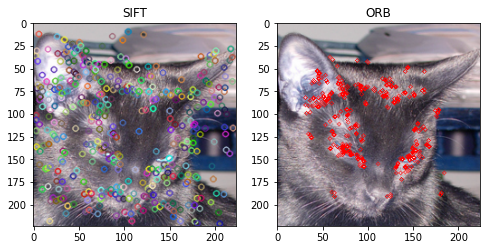

In [117]:
# load a test img
idx = np.random.randint(100)
# idx = 10
test_img = cv2.imread(cat_imgs_path[idx])

sift = cv2.SIFT_create()
kp1, des1 = sift.detectAndCompute(test_img, None)
img_SIFT = cv2.drawKeypoints(test_img, kp1, test_img)

fig = plt.figure(figsize=(8,8))

ax1 = fig.add_subplot(1,2,1)
ax1.imshow(img_SIFT)
plt.title('SIFT')

test_img = cv2.imread(cat_imgs_path[idx])

# Extract and plot keypoints
orb = cv2.ORB_create()
kp = orb.detect(test_img, None)
kp, des = orb.compute(test_img, kp)

for k in kp:
    x, y = k.pt
    test_img = cv2.circle(test_img, (int(x), int(y)), 2, (255, 0, 0))
    
ax2 = fig.add_subplot(1,2,2)
ax2.imshow(test_img)
plt.title('ORB')

plt.show()

# BoVW

## 1. Load images 

In [3]:
def load_images_from_txt(txt_filename):
    """
    Load imgs from .txt file with paths of imgs. 
    """
    with open(txt_filename) as f:
        paths = f.readlines()
    f.close()
    
    images = {'cat': [], 'dog': []}
    for path in paths:
        img = cv2.imread(path[:-1])
        
        if img is not None:
            images[path[12:15]].append(img)
    return images

In [4]:
A_train = load_images_from_txt('data_folds/A_train.txt')
A_val = load_images_from_txt('data_folds/A_val.txt')

B_train = load_images_from_txt('data_folds/B_train.txt')
B_val = load_images_from_txt('data_folds/B_val.txt')

C_train = load_images_from_txt('data_folds/C_train.txt')
C_val = load_images_from_txt('data_folds/C_val.txt')

## 2. Extract features

In [5]:
def sift_features(images):
    sift_vectors = {}
    descriptor_list = []
    sift = cv2.xfeatures2d.SIFT_create()
    for key,value in images.items():
        features = []
        for img in value:
            kp, des = sift.detectAndCompute(img,None)
            descriptor_list.extend(des)
            features.append(des)
        sift_vectors[key] = features
    return [descriptor_list, sift_vectors]

# sifts = sift_features(images) 
# Takes the descriptor list which is unordered one
# descriptor_list = sifts[0] 
# Takes the sift features that is seperated class by class for train data
# all_bovw_feature = sifts[1] 
# Takes the sift features that is seperated class by class for test data
# test_bovw_feature = sift_features(test)[1] 


def extract_features(images):
    
    orb_vectors = {}
    descriptor_list = []
    
    orb = cv2.ORB_create()
    
    for cls, value in images.items():
        features = []
        for img in value:      
            kp = orb.detect(img, None)
            kp, des = orb.compute(img, kp)         
            
            descriptor_list.extend(des)
            features.append(des)
            
        orb_vectors[cls] = features
        
    return [descriptor_list, orb_vectors]

In [6]:
orb_desc = extract_features(A_train) 

# Takes the descriptor list which is unordered one
descriptor_list = orb_desc[0] 

# Takes the orb features that is seperated class by class for train data
all_bovw_feature = orb_desc[1] 

In [20]:
len(descriptor_list)

173140

In [13]:
len(all_bovw_feature['cat'][1])

92

## 3. K-Means

In [149]:
from sklearn.cluster import KMeans

In [21]:
def kmeans(k, descriptor_list):
    kmeans = KMeans(n_clusters = k, verbose=1,n_init=3)
    kmeans.fit(descriptor_list)
    visual_words = kmeans.cluster_centers_ 
    return visual_words
    
# Takes the central points which is visual words    
visual_words = kmeans(200, descriptor_list) 

In [151]:
len(visual_words)

200

## 4. Create Histograms

In [152]:
from scipy.spatial import distance

# takes two arrays as parameters and find the l1 distance
def L1_dist(vec1, vec2):
    return np.linalg.norm(np.subtract(np.array(vec1), np.array(vec2)))    

def find_index(image, center):
    count = 0
    ind = 0
    for i in range(len(center)):
        if(i == 0):
            count = distance.euclidean(image, center[i]) 
           #count = L1_dist(image, center[i])
        else:
            dist = distance.euclidean(image, center[i]) 
            #dist = L1_dist(image, center[i])
            if(dist < count):
                ind = i
                count = dist
    return ind

def image_class(all_bovw, centers):
    dict_feature = {}
    for key,value in all_bovw.items():
        category = []
        print(key)
        for idx, img in enumerate(value):
            histogram = np.zeros(len(centers))
            for each_feature in img:
                ind = find_index(each_feature, centers)
                histogram[ind] += 1
            category.append(histogram)
            if(idx%100 == 0):
                print(idx)
        dict_feature[key] = category
    return dict_feature
    
# Creates histograms for train data    
bovw_train = image_class(all_bovw_feature, visual_words) 
# Creates histograms for test data
# bovw_test = image_class(test_bovw_feature, visual_words) 

cat
0
100
200
dog
0
100
200


In [30]:
import csv
with open('all_bovw_feature.csv', 'w') as f:
    for key in all_bovw_feature.keys():
        f.write("%s,%s\n"%(key,all_bovw_feature[key]))
        
with open('bovw_train.csv', 'w') as f:
    for key in bovw_train.keys():
        f.write("%s,%s\n"%(key,bovw_train[key]))

with open("visual_words.csv", "w", newline="") as f:
    writer = csv.writer(f)
    writer.writerows(visual_words)

In [155]:
from sklearn.svm import LinearSVC
clf=LinearSVC(max_iter=100000, verbose=1)
# clf.fit(im_features,np.array(y_train))

In [157]:
cats = np.array(bovw_train['cat'])

In [158]:
dogs = np.array(bovw_train['dog'])

In [162]:
classes = np.zeros(cats.shape[0]+dogs.shape[0])
classes[:cats.shape[0]] = 1

In [163]:
all_hists = np.vstack((cats,dogs))

In [164]:
clf.fit(all_hists,classes)

[LibLinear]

LinearSVC(max_iter=100000, verbose=1)

In [165]:
predict_classes = []
for i in clf.predict(all_hists):
    if i==1:
        predict_classes.append("Cat")
    else:
        predict_classes.append("Dog")

In [166]:
predict_classes[:cats.shape[0]].count('Cat')

242

In [167]:
predict_classes[cats.shape[0]:].count('Dog')

242

In [168]:
cats.shape

(276, 200)